In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
import findspark
from pyspark.sql.functions import *

In [2]:
findspark.init()
findspark.find()

'C:\\Spark\\spark-3.0.3-bin-hadoop2.7'

In [3]:
spark = SparkSession \
.builder \
.appName("Phân tích điểm thi đai học") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()


# Import all file csv from data folder

In [4]:
path = "./data"
AllCSV = [i for i in glob.glob(path+ "/*.csv")]
AllCSV

['./data\\Diemthi2019.csv',
 './data\\Diemthi2020.csv',
 './data\\Diemthi2021.csv']

# Read csv

In [5]:
all_dataframes = [] # list to store each data frame separately
for csv in AllCSV:
    df = spark.read.csv(csv, header = True)
    all_dataframes.append(df)

In [7]:
df_2020 = all_dataframes[1]
df_2020.show(5)

+--------+----+-------+---------+------+-------+--------+-------+------+----+------+
|     SBD|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|Ma_cum|
+--------+----+-------+---------+------+-------+--------+-------+------+----+------+
|01000001| 7.0|    6.0|     null|  null|   null|    null|    8.0|  null|null|    01|
|01000002| 9.0|    6.0|      9.4|  7.25|   8.75|    7.25|   null|  null|null|    01|
|01000003| 8.8|    6.5|      6.0|  8.25|   8.75|    4.75|   null|  null|null|    01|
|01000004| 7.0|   null|      8.2|  null|    6.0|    null|   null|  null|null|    01|
|01000005| 9.0|    7.5|      9.2|  null|   null|    null|   5.75|  7.25|9.25|    01|
+--------+----+-------+---------+------+-------+--------+-------+------+----+------+
only showing top 5 rows



In [8]:
df_2021 = all_dataframes[2]
df_2021.show(5)

+-------+----+-------+---------+------+-------+--------+-------+------+----+-------+
|    SBD|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|Cum_thi|
+-------+----+-------+---------+------+-------+--------+-------+------+----+-------+
|1000001| 2.2|    3.5|     null|  null|   null|    null|    2.5|   5.5|null|      1|
|1000002| 9.2|   8.25|       10|  null|   null|    null|   5.75|  9.75|9.25|      1|
|1000003| 4.4|   6.25|     null|  null|   null|    null|   4.25|     4|null|      1|
|1000004| 8.4|   6.75|       10|     4|      3|     3.5|   null|  null|null|      1|
|1000005| 8.8|   8.25|      9.4|  8.25|   5.75|    5.25|   null|  null|null|      1|
+-------+----+-------+---------+------+-------+--------+-------+------+----+-------+
only showing top 5 rows



# Xử Lý data 2020 và 2021

In [9]:
df_2020 = df_2020.drop('SBD','Ma_cum')
df_2021 = df_2021.drop('SBD','Cum_thi')

In [107]:
Datas = []
for  val in [df_2020,df_2021]:
    data = val.withColumn('Toan', F.col('Toan').cast(FloatType()))\
        .withColumn('Ngu_van', F.col('Ngu_van').cast(FloatType()))\
        .withColumn('Ngoai_ngu',F.col('Ngoai_ngu').cast(FloatType()))\
        .withColumn('Vat_ly', F.col('Vat_ly').cast(FloatType()))\
        .withColumn('Hoa_hoc', F.col('Hoa_hoc').cast(FloatType()))\
        .withColumn('Sinh_hoc', F.col('Sinh_hoc').cast(FloatType()))\
        .withColumn('Lich_su', F.col('Lich_su').cast(FloatType()))\
        .withColumn('Dia_ly', F.col('Dia_ly').cast(FloatType()))\
        .withColumn('GDCD', F.col('GDCD').cast(FloatType()))
    Datas.append(data)

In [109]:
df_2020 = Datas[0]
df_2021 = Datas[1]

In [110]:
df_2020.show(3)

+----+-------+---------+------+-------+--------+-------+------+----+
|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|
+----+-------+---------+------+-------+--------+-------+------+----+
| 7.0|    6.0|     null|  null|   null|    null|    8.0|  null|null|
| 9.0|    6.0|      9.4|  7.25|   8.75|    7.25|   null|  null|null|
| 8.8|    6.5|      6.0|  8.25|   8.75|    4.75|   null|  null|null|
+----+-------+---------+------+-------+--------+-------+------+----+
only showing top 3 rows



# move to pandas

In [18]:
df_2020p = df_2020.toPandas()
df_2021p = df_2021.toPandas()

# Check Missing values

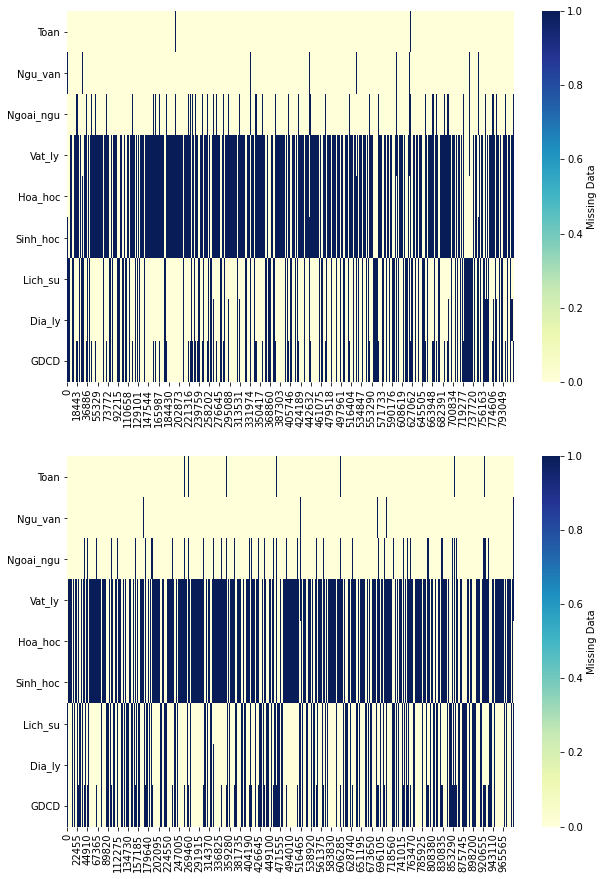

In [22]:
fig, ax = plt.subplots(2,figsize = (10,15))
for idx, val in enumerate([df_2020p,df_2021p]):
    sns.heatmap(val.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'},ax = ax[idx])

# Tính điểm các khối A00, A01, B01, C01, D01

In [23]:
for  val in [df_2020p,df_2021p]:
    val['KhoiA'] = val['Toan'] + val['Vat_ly'] + val['Hoa_hoc']
    val['KhoiB'] = val['Toan'] + val['Sinh_hoc'] + val['Hoa_hoc']
    val['KhoiC'] = val['Ngu_van'] + val['Lich_su'] + val['Dia_ly']
    val['KhoiA1'] = val['Toan'] + val['Vat_ly'] + val['Ngoai_ngu']
    val['KhoiD1'] = val['Toan'] + val['Ngu_van'] + val['Ngoai_ngu'] 

In [102]:
def Draw_phodiem( df_2020p,df_2021p, mon_hoc,tittle):
    #2021
    data_show_2021 = df_2021p[mon_hoc]
    data_show_2021 = data_show_2021.apply(lambda x: np.round(x,2))
    bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
    cats = pd.cut(data_show_2021.sort_values(), bins)
    data_show_2021 = pd.value_counts(cats).sort_index()
    #2020
    data_show_2020 = df_2020p[mon_hoc]
    data_show_2020 = data_show_2020.apply(lambda x: np.round(x,2))
    cats = pd.cut(data_show_2020.sort_values(), bins)
    data_show_2020 = pd.value_counts(cats).sort_index()
    
    show =  pd.DataFrame(data_show_2020)
    show['2021'] =  data_show_2021
    show= show.rename(columns = {'KhoiA': '2020'})
    show.plot(kind='bar', colormap='plasma', figsize =(15,8))
    plt.title("Phổ điểm "+tittle)
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
    font_title = {'family': 'serif',
                'color':  'black',
                'weight': 'normal',
                'size': 16,
                }

    plt.grid()
    plt.xlabel('Điểm', labelpad=10, fontdict=font)
    plt.ylabel('Số lượng', labelpad=15, fontdict=font)
    plt.tight_layout()
    plt.show()
    return 

In [104]:
ma_Monhoc = [
    {'Mon_hoc':'KhoiA', 'Ten': 'Khối A00'},
    {'Mon_hoc':'KhoiB', 'Ten': 'Khối B00'},
    {'Mon_hoc':'KhoiD1', 'Ten': 'Khối D01'},
    {'Mon_hoc':'KhoiA1', 'Ten': 'Khối A01'},
]

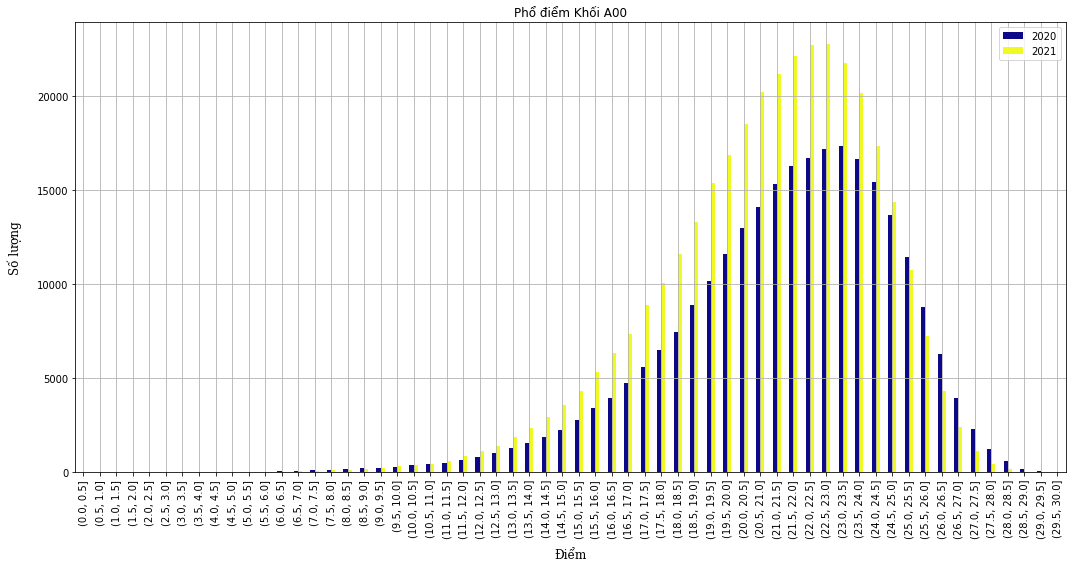

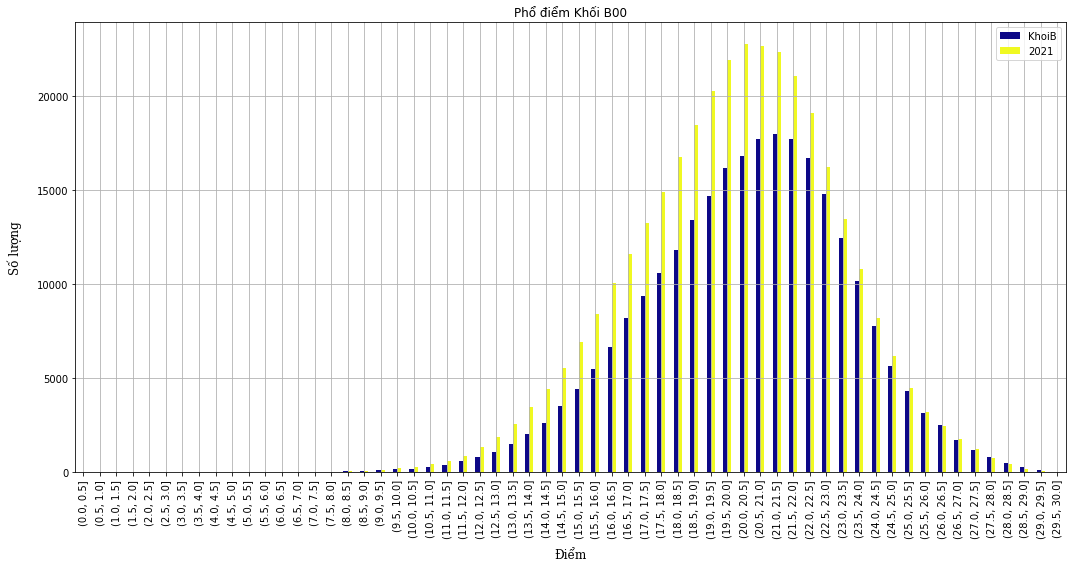

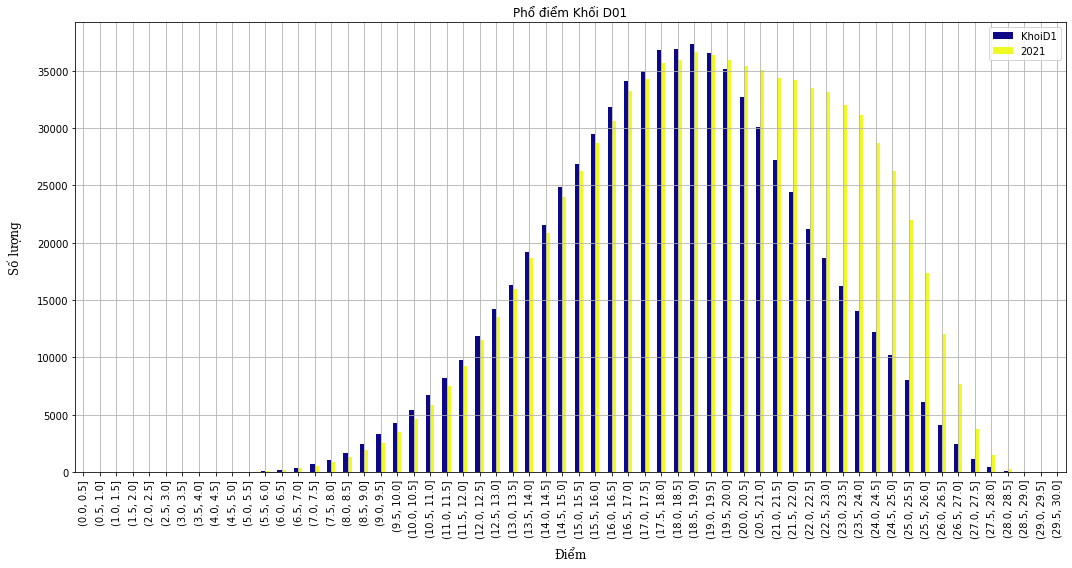

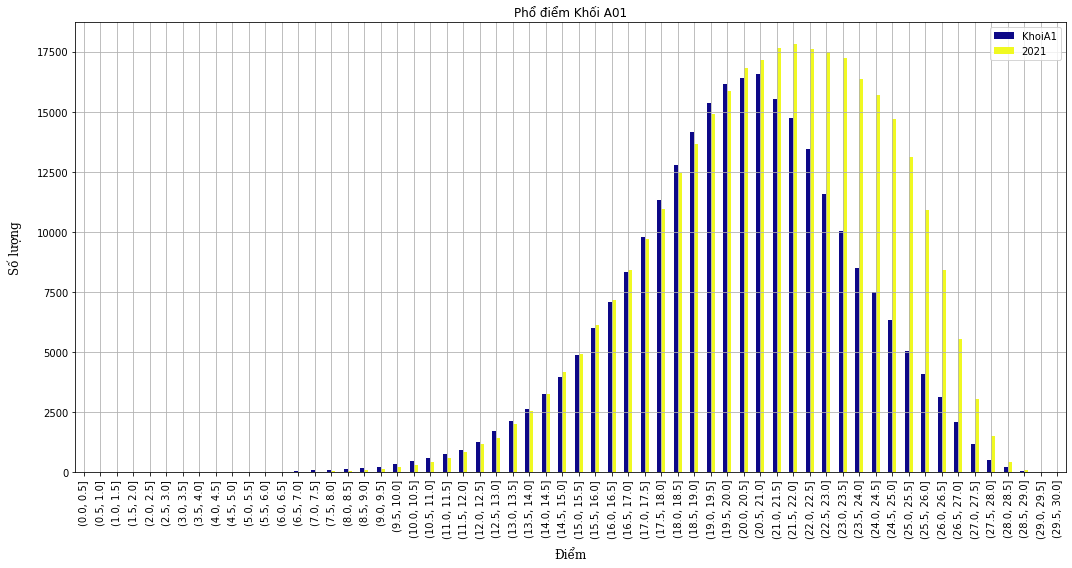

In [105]:
for val in ma_Monhoc:
    Draw_phodiem(df_2020p,df_2021p, val['Mon_hoc'], val['Ten'])

 # Nhìn vào biểu đồ khối A có thể thấy rằng: 
 - năm 2021 số lượng thí sinh có điểm trong khoảng [22.5; 23.0] là cao nhất, còn năm 2020 thì nằm trong khoảng [23.0;23.5]
 - Bắt đầu từ mức 25 điểm trở lên thì số lượng thí sinh năm 2020 nhỉnh hơn năm 2021 một lượng nhỏ. Nếu các trường đại học vẫn giữ mức số lượng chỉ tiêu tuyển sinh cho kỳ thi THPTQG như năm 2020, thì ta có dự đoán rằng những ngành có mức điểm chuẩn từ năm 2020 có thể giảm nhẹ từ 0.5 đến 1 điểm.
 - Khoảng điểm từ 23 đên 25 có thể tăng nhẹ từ 1 đến 2 điểm.
 - Còn đối với các điểm từ 23 đổ xuống có thể tăng mạnh từ 2 đến 3 điểm, vì độ chênh lệch khá cao.

Như vậy các thí sinh đạt điểm từ 25 trở lên, thì yên đạt nguyện vọng vào các ngành có điểm chuẩn 25 điểm, còn các sinh viên còn lại phải cân nhắc kỹ khi đạt nguyện vọng vào các ngành có điểm ngang bằng với điểm thi của mình.

# Nhìn hai biểu đồ phổ điểm khối A01 và D01 nhìn có vẻ khá tương đồng nhau nên ta có thể đưa ra nhận xét chung.
- Ta có thể số lượng thí sinh của hai khối này đạt mức điểm từ 21 đến 26 điểm năm 2021 cao hơn nhiều so với năm 2020. Với mức chênh lệch cao như vậy ta có thể ước lượng điểm chuẩn nằm trong khoảng này sẽ tăng rất mạnh khoảng từ 3 đến 4 điểm.
- Vùng từ 26 đổ lên với sự chênh lệch nhẹ có thể tăng từ 1 đên 1.5 điểm.


# Nhìn chung điểm chuẩn khối B từ mức khoản 23 điểm trở lên sẽ không có sự biến đổi nhiều. Các điểm chuẩn dưới 23 điểm nếu vẫn giữ mức chỉ tiêu cso thể tăng nhẹ.

In [121]:
df_2021p.head()

,Toan,Ngu_van,Ngoai_ngu,Vat_ly,Hoa_hoc,Sinh_hoc,Lich_su,Dia_ly,GDCD,KhoiA,KhoiB,KhoiC,KhoiA1,KhoiD1
0,2.2,3.50,NaN,NaN,NaN,NaN,2.50,5.50,NaN,NaN,NaN,11.50,NaN,NaN
1,9.2,8.25,10.0,NaN,NaN,NaN,5.75,9.75,9.25,NaN,NaN,23.75,NaN,27.450001
2,4.4,6.25,NaN,NaN,NaN,NaN,4.25,4.00,NaN,NaN,NaN,14.50,NaN,NaN
3,8.4,6.75,10.0,4.00,3.00,3.50,NaN,NaN,NaN,15.400000,14.900000,NaN,22.400000,25.150000
4,8.8,8.25,9.4,8.25,5.75,5.25,NaN,NaN,NaN,22.799999,19.799999,NaN,26.449999,26.449999


In [129]:
Tieng_anh = df_2021p.Ngoai_ngu.value_counts().sort_index()
Tieng_anh.index = Tieng_anh.index.to_series().apply(lambda x: np.round(x,2))

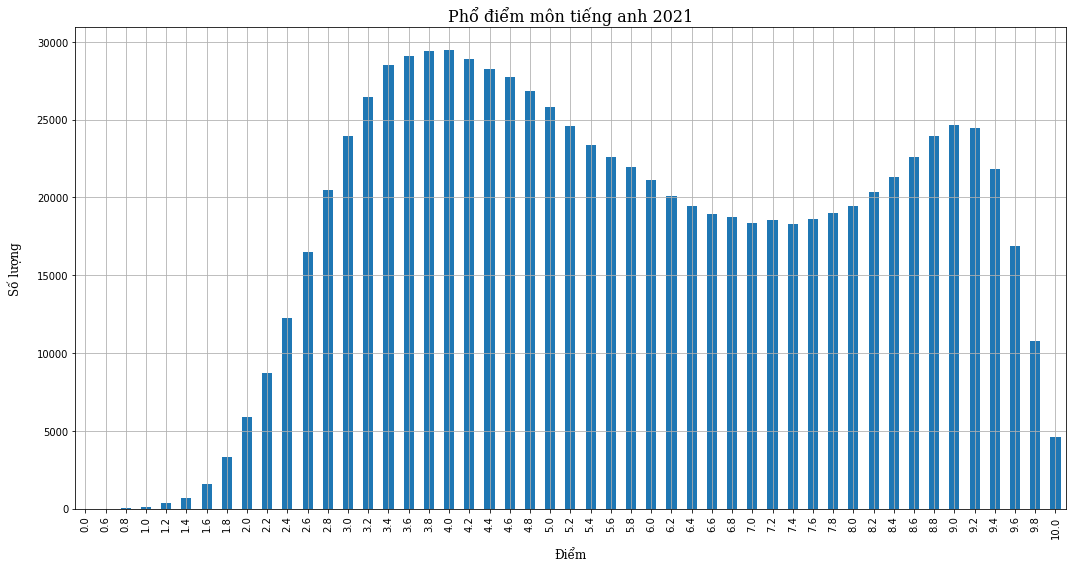

In [131]:
Tieng_anh.plot(kind = 'bar', rot = 90, figsize =(15,8))
font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
font_title = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    
plt.grid()
plt.xlabel('Điểm', labelpad=10, fontdict=font)
plt.ylabel('Số lượng', labelpad=15, fontdict=font)

plt.title("Phổ điểm môn tiếng anh 2021", fontdict=font_title)
plt.tight_layout()
plt.show()


Ta có thể thấy rằng phổ điểm Tiếng anh của thí sinh 2021 xuất hiện 2 đỉnh hình chuông. Từ đó nó liệu ta có thể nhận xét rằng có sự phân hoá giữa thí sinh thành thị được học trong môi trường phát triển tốt và các thí sinh nông thôn có sự thiệt thòi về môi trường và thiết bị hỗ trợ hay không?.Việc các trường đại học công nhận quy đổi điểm Ielts sang điểm thi đại học môn Tiếng anh cũng có thể gây lên biểu đồ này, với những thí sinh ở nông thôn rất khó để tiếp cận đến với ielts vì chi phí theo học là rất tốn kém Vd: một buổi học thêm Tiếng Anh ngoài giờ hiện nay ở ngoại thành Hà Nội có giá giao động vào khoảng 30-5ok/2h,nhưng giá của một buổi học ielts vào khoảng từ 200k-500k/2h. Với mức giá như vậy, ta so với thu nhập bình 1 tháng của các gia đình nông thôn thì nó là một chi phí khổng lồ. Nên ta cũng có thể kết luận rằng việc đồ thị phân phối trên có thể cho thấy một chút sự phân hoá vùng miền giữ nông thôn và thành thị.
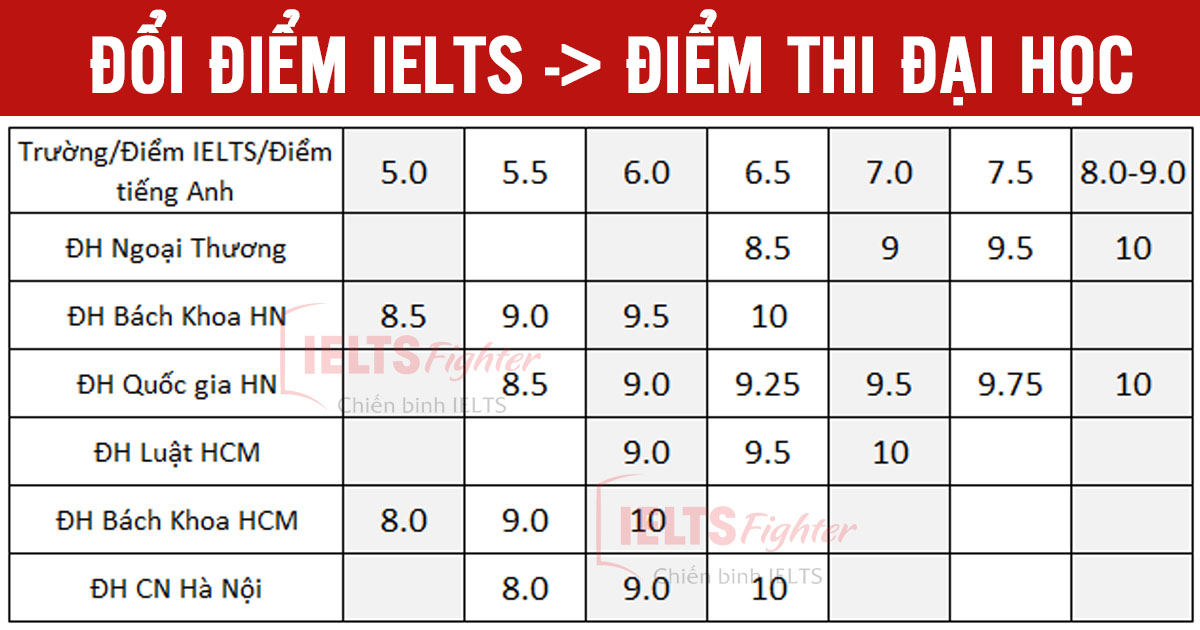
